In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

from jax import jit, value_and_grad
import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

global_cache_data_digital = None
global_processed_files_digital = None

In [2]:
from readin_data_runs import get_cached_data_once_digital,save_cached_data, process_new_files_digital

num_epochs = 1500
# # Process files by each N_ctrl and update the cache independently
# cached_data_analog_nctrl3 , processed_files_analog_nctrl3 = get_cached_data_direct_path(nctrl3_path, N_ctrl)
# Main loop for different N_ctrl values
N_ctrls = [1, 2,3]
num_train = 20
reservoir_counts = [1, 2, 3,4,5,6,7,8]
processed_files_global_digital = set()
# base_path = f'/Users/sophieblock/QRCCapstone/gate_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_opt/'
base_path = f'/Users/sophieblock/QRCCapstone/gate_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_costcut_1e-8/'
# base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_costcut_1e-10/'

cached_data_digital, processed_files_digital = get_cached_data_once_digital(base_path)
print(cached_data_digital.keys())


dict_keys([2])


In [3]:
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    


    trots = np.arange(1, 54, 1)

    # Process files and update the cache
    cached_data_digital, processed_files_digital = process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data_digital, processed_files_digital, N_ctrl)

    save_cached_data(base_path, cached_data_digital, processed_files_digital)
    processed_files_global_digital.update(processed_files_digital)

Processing for N_ctrl = 1
Processing for N_ctrl = 2
Processing for N_ctrl = 3


In [12]:
def get_dataframe(cached_data_temp, model_type = "Digital",N_ctrls = [1]):
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        original = results.get('test_results', [])
                        new_vals = []
                        for f in original:
                            if f > 1.0:
                                delta = f - 1.0       # how far above 1.0
                                reflected = 1.0 - delta  # reflect about 1.0
                                # If 'reflected' dips below 0 (which can happen if f>2),
                                # you might clamp it to 0.0 or do something else:
                                if reflected < 0:
                                    reflected = 0.0
                                print(f"[PASS 1] Reflecting fidelity {f:.6f} about 1.0 => {reflected:.6f} "
                                    f"(Gate={gate}, N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step})")
                                new_vals.append(reflected)
                            else:
                                new_vals.append(f)
                        results['test_results'] = new_vals
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        # Just clamp any test_results fidelity to <= 1.0
                        original = results.get('test_results', [])
                        clamped_vals = [min(1.0, f) for f in original]
                        results['test_results'] = clamped_vals
                        
    tmp_rows = []
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        row = {
                            'Type': model_type,
                            'N_C': N_ctrl,
                            'Gate': gate,
                            'N_R': reservoir_count,
                            'Trotter_Step': trotter_step,
                        }
                        # Include *all* keys from `results` so we don't drop anything
                        for k, v in results.items():
                            row[k] = v

                        tmp_rows.append(row)

    tmp_df = pd.DataFrame(tmp_rows)
        
   

    def keep_iqr_5_95(arr):
        # If array empty or all identical, just return it
        if len(arr) < 2:
            return arr
        p5, p95 = np.percentile(arr, [0, 95])
        filtered = [x for x in arr if p5 <= x <= p95]
        # If everything got filtered out, you could decide to keep them all
        # or do something else. Here we allow an empty list if it's all outliers.
        return filtered if filtered else arr

    # tmp_df['test_results'] = tmp_df['test_results'].apply(keep_iqr_5_95)

    tmp_df['avg_fidelity'] = tmp_df['test_results'].apply(
        lambda arr: np.mean(arr) if len(arr) else 1.0
    )

    group_cols = ['N_C', 'N_R', 'Trotter_Step']
    tmp_df['local_max_avg_fid'] = (
        tmp_df.groupby(group_cols)['avg_fidelity'].transform('max')
    )


    def fix_any_ones_partially(row):
        arr = row['test_results']
        if len(arr) > 0 and any(x == 1.0 for x in arr):
            local_max = row['local_max_avg_fid']
            new_arr = []
            for x in arr:
                if x == 1.0:
                    new_arr.append(local_max)
                else:
                    new_arr.append(x)
            print(f"[PASS 2] Partially replacing any 1.0 entries "
                f"with local_max_avg_fid={local_max:.4e} "
                f"(Gate={row['Gate']}, N_C={row['N_C']}, "
                f"N_R={row['N_R']}, T={row['Trotter_Step']})")
            return new_arr
        return arr
    tmp_df['test_results'] = tmp_df.apply(fix_any_ones_partially, axis=1)

    
    ##############################################################################
    # WRITE BACK THE UPDATED `test_results` INTO `cached_data_temp`
    # so your original code snippet can run unmodified.
    ##############################################################################
    for idx, row in tmp_df.iterrows():
        N_ctrl = row['N_C']
        gate = row['Gate']
        reservoir_count = row['N_R']
        trotter_step = row['Trotter_Step']
        
        # Find matching entry in the results_list
        results_list = cached_data_temp[N_ctrl][gate][reservoir_count][trotter_step]
        found_entry = False
        for results in results_list:
            # If you have a unique 'run' key, match on that
            if 'run' in row and results.get('run') == row['run']:
                results['test_results'] = row['test_results']
                found_entry = True
                break

        # If you have no unique ID, you must figure out a safe way to match
        # For now, we skip if not found:
        if not found_entry:
            pass



    ##############################################################################
    # PASS 2: RUN YOUR ORIGINAL CODE TO BUILD THE FINAL `all_data_df` WITH ALL KEYS
    ##############################################################################
    rows = []
    negative_fidelity_values = []
    def keep_iqr_5_95(arr,a = 5,b = 95):
        # If array empty or all identical, just return it
        if len(arr) < 2:
            return arr
        p5, p95 = np.percentile(arr, [a, b])
        filtered = [x for x in arr if p5 <= x <= p95]
        # If everything got filtered out, you could decide to keep them all
        # or do something else. Here we allow an empty list if it's all outliers.
        return filtered if filtered else arr
    global_min_error = 100  # from your snippet

    for N_ctrl in N_ctrls:
        data_i = cached_data_temp[N_ctrl]
        for gate, gate_data in data_i.items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        avg_fidelity = results.get('fidelity', np.nan)
                        std_fidelity = np.nanstd(results.get('test_results', []))

                        if pd.isna(avg_fidelity):
                            raise ValueError(
                                f"NaN in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                                f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, "
                                f"Run: {results.get('run', None)}"
                            )

                        log_infidelities = []
                        infidelities, fidelities = [], []
                        num_clipped = {}
                        all_og_fidelities = {}

                        test_results = results.get('test_results', [])
                        optimal_min_error = None
                        optimal_jitter_scale = None

                        # Step 1: dynamic min_error + jitter
                        non_clipped_fids = [
                            f for f in test_results
                            if 0 < f < 1.0
                        ]
                        if non_clipped_fids:
                            sorted_valid = sorted(non_clipped_fids)
                            n = len(sorted_valid)
                            std_dev = np.std(sorted_valid)
                            std_err = std_dev / np.sqrt(n) if n > 1 else global_min_error
                            optimal_min_error = 1.0 - sorted_valid[-1]
                            if global_min_error > optimal_min_error:
                                global_min_error = max(1e-9, optimal_min_error)
                            optimal_jitter_scale = (
                                std_dev / 2
                                if std_dev/2 < optimal_min_error
                                else optimal_min_error
                            )
                        else:
                            optimal_min_error = global_min_error
                            optimal_jitter_scale = global_min_error

                        # Step 2: Process each fidelity
                        clipped_count = 0
                        for i, f in enumerate(test_results):
                            all_og_fidelities[i] = f
                            inf = 1.0 - f

                            if inf <= 1e-8:
                                clipped_count += 1
                                jitter = np.random.uniform(-optimal_jitter_scale, 
                                                        optimal_jitter_scale)
                                num_clipped[i] = {'fidelity': f, 'jit': jitter}
                                inf = optimal_min_error + jitter
                                # print(f'triggered')
                                # print(f"\nGate={results['gate']} => test_results stats:")
                                # print(f"  Min={np.min(test_results):.7e}, Max={np.max(test_results)}, Var={np.var(test_results)}, Mean={np.mean(test_results):.9f}")
                                assert inf > 0, (
                                    f"Adjusted infidelity is non-positive: i={i}, "
                                    f"min_error={optimal_min_error}, jitter={jitter}."
                                )
                                f = 1.0 - inf

                            infidelities.append(inf)
                            fidelities.append(f)
                            log_infidelities.append(np.log10(inf))

                        # Step 3: Build row
                        avg_fidelity = np.mean(fidelities)
                        avg_infidelity = np.mean(infidelities)

                        row = {
                            'Type': model_type,
                            'N_C': int(N_ctrl),
                            'Trotter_Step': int(trotter_step),
                            'Gate': results['gate'],
                            'N_R': int(reservoir_count),
                            'Avg_Fidelity': avg_fidelity,
                            'std_fidelity': std_fidelity,
                            'Avg_infidelity': avg_infidelity,
                            'var_infid': np.var(infidelities),
                            'Error_Test_Results': keep_iqr_5_95(log_infidelities,a=10,b=100),
                            'Avg Error': (np.nanmean(log_infidelities) 
                                        if log_infidelities else np.nan),
                            'infidelities': keep_iqr_5_95(infidelities, a = 20, b = 100),
                            'fidelities':  keep_iqr_5_95(fidelities, a = 0, b = 95),
                            'Costs': results.get('costs', []),
                            'Test Results': test_results,
                            'N_params': results.get('param_count', np.nan),
                            'run': results.get('run', None),
                           
                          
                        }

                        rows.append(row)

    all_data_df = pd.DataFrame(rows)
    return all_data_df
print(cached_data_digital.keys())
all_data_df = get_dataframe(cached_data_digital, "Digital", N_ctrls=[2])

dict_keys([2])


global_min_y: -9.24268240752148, global_max_y: -0.0012666403166308156
global_min_fidelity: 0.3039330963697945, global_max_fidelity: 0.9999999546860505


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_78658/1052183224.py:116: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='N_R', data=test_results_df,


y ticks: [-10.  -8.  -6.  -4.  -2.   0.   2.], -9
[-8. -7. -6. -5. -4. -3. -2. -1.  0.]


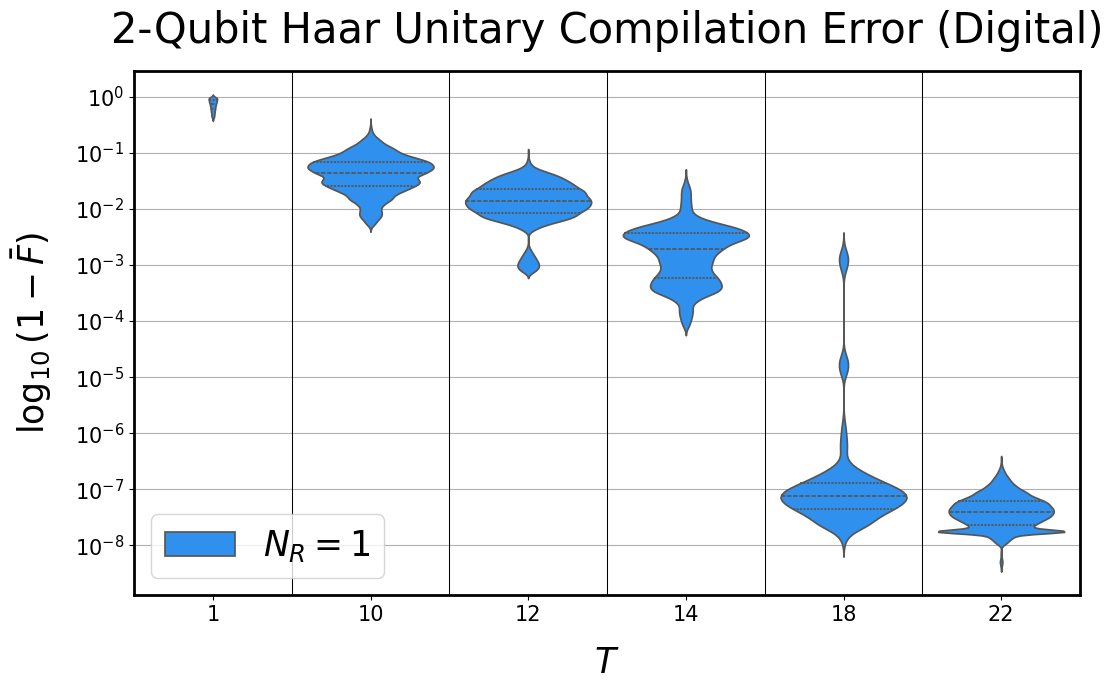

y ticks: [-10.  -8.  -6.  -4.  -2.   0.   2.]

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_78658/1052183224.py:180: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_filtered,


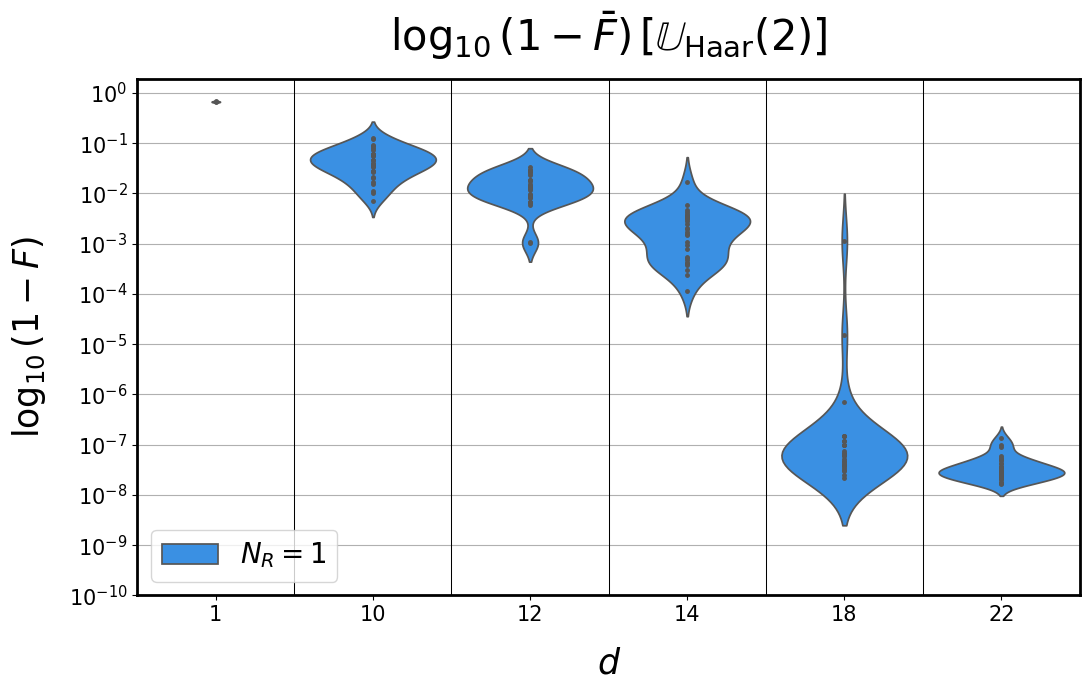

In [13]:
# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_max_y = float('-inf')
global_min_fidelity = float('inf')
global_max_fidelity = float('-inf')

custom_palette = ['dodgerblue', 'gold', 'violet'] 
plt.close('all')  # Close previous figures to avoid conflicts
N_ctrls = [2]
resies = [1,2,3,4,5,6,7,8,9]
resies = [1]
for N_ctrl in N_ctrls:
    trots = np.arange(1,54,1)
    
    if N_ctrl == 2:
        trots = set(trots)
        # trots.remove(np.int64(6))
        
    elif N_ctrl == 1:
        trots = set(trots)
        
    elif N_ctrl == 3:
        trots = set(trots)
        trots.remove(np.int64(32))
        trots.remove(np.int64(36))
        trots.remove(np.int64(1))
        trots.remove(np.int64(42))
        trots.remove(np.int64(47))

    
    

    trots = list(trots)
   

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Aggregate average fidelity by Trotter_Step and N_R
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'N_R'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)

# Add a slight margin to avoid cutoff on the plot
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y += margin_factor * abs(global_max_y)

print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")
plot_avgered = True
custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    trots = np.arange(1,54,1)
    
    if N_ctrl == 2:
        trots = set(trots)
        # trots.remove(np.int64(6))
        
    elif N_ctrl == 1:
        trots = set(trots)
        
    elif N_ctrl == 3:
        trots = set(trots)
        trots.remove(np.int64(32))
        trots.remove(np.int64(36))
        trots.remove(np.int64(1))
        trots.remove(np.int64(42))
        trots.remove(np.int64(47))
    trots = list(trots)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['N_R'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error_Test_Results')

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Drop rows with NaN values in 'Error_Test_Results' to avoid errors
    test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(11, 7))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    # sns.violinplot(x='Trotter_Step', y='infidelities', hue='N_R', data=test_results_df, 
    #                ax=axs,width=0.8, palette=custom_palette,log_scale=True, density_norm='count', inner='quartile', saturation=0.85)
    sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='N_R', data=test_results_df, 
                   ax=axs,width=0.8, palette=custom_palette,density_norm='count', inner='quartile', saturation=0.85)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=30, pad=20)
    
    axs.set_xlabel('$T$', fontsize=25, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=25, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # # Set the global Y-limits
    # axs.set_ylim(global_min_y, global_max_y)

    # # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    print(f"y ticks: {y_ticks}, {round(global_min_y)}")
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = round(global_min_y)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
    print(whole_y_ticks)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=15)
    axs.tick_params(axis='x', labelsize=15)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    # plt.tight_layout(pad=3.0)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()
    if plot_avgered:
        # Filter the DataFrame for specific Trotter_Steps
        data_filtered = data_df[data_df['Trotter_Step'].isin(trots)]

        ### First Violin Plot for Average Error ###

        fig, axs = plt.subplots(1, figsize=(11, 7))

        # Set the linewidth of the outside border (spines)
        for spine in axs.spines.values():
            spine.set_linewidth(2)  # Set linewidth to 2 pixels

        # Violin Plot for Average Error (log10(1 - avg_fidelity))
        sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_filtered, 
                    ax=axs, palette=custom_palette, density_norm='count', inner="point")

        # Set titles and labels with padding
        axs.set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=30, pad=20)
        axs.set_xlabel('$d$', fontsize=25, labelpad=15)  # X-axis label with padding
        axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=25, labelpad=15)  # Y-axis label with padding

        # Add grid lines
        axs.yaxis.grid(True)
        axs.xaxis.grid(False)
        axs.set_axisbelow(True)

        # Customize the legend
        handles, labels = axs.get_legend_handles_labels()
        axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)

        # Set Y-ticks and labels
        y_ticks = axs.get_yticks()
        print(f"y ticks: {y_ticks}")
        whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
        # print(whole_y_ticks)
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        # print(whole_y_ticks)
        
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

        # Set tick parameters
        axs.tick_params(axis='y', labelsize=15) 
        axs.tick_params(axis='x', labelsize=15) 

        # Add vertical lines to separate groups
        unique_trotter_steps = data_filtered['Trotter_Step'].unique()
        positions = range(1, len(unique_trotter_steps), 1)
        for pos in positions:
            axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

        # Show the plot
        plt.tight_layout()
        plt.show()

#         global_min_y: -12.778103701617654, global_max_y: -0.0012666403166308156
# global_min_fidelity: 0.3039330963697945, global_max_fidelity: 0.9999999546932293

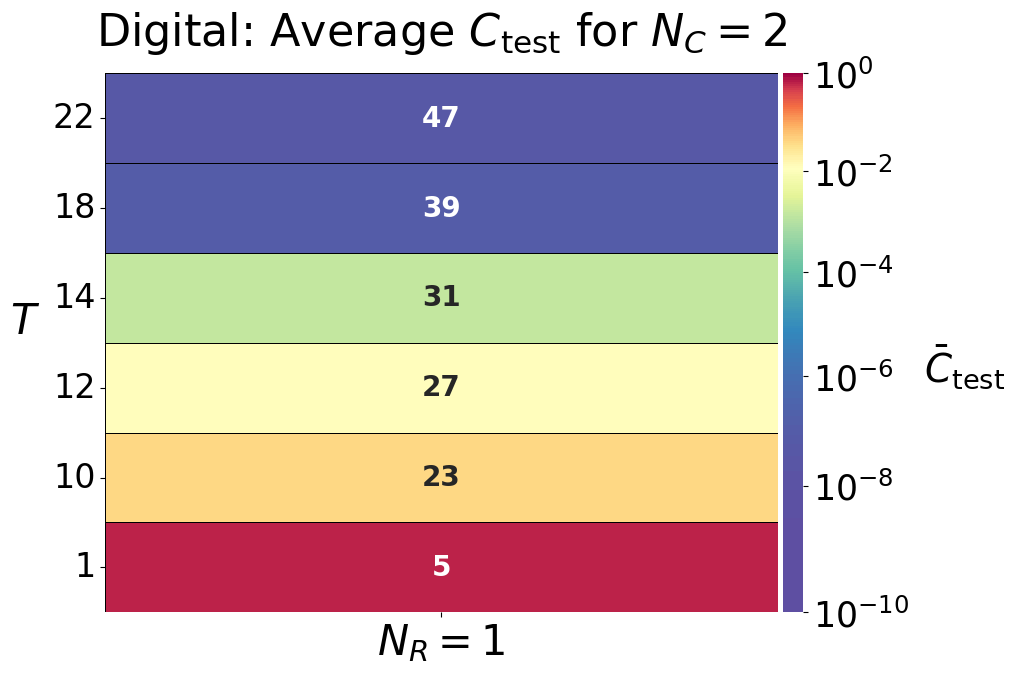

In [14]:
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
class ExaggeratedPowerNorm(Normalize):
    def __init__(self, gamma, vmin=None, vmax=None, clip=False):
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)
        self.gamma = gamma

    def __call__(self, value, clip=None):
        vmin, vmax = self.vmin, self.vmax
        if vmin is None or vmax is None:
            raise ValueError("You must set both vmin and vmax for normalization")
        normalized = (value - vmin) / (vmax - vmin)  # Normalize to [0, 1]
        return normalized ** self.gamma  # Exaggerate higher values
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

from matplotlib.colors import LinearSegmentedColormap


base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()

resies = [1,2,3,4,5,6]
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 17,18,19,20,21,22, 24,26]
        # trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['N_R'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and N_R
    averaged_data = data_df.groupby(['Trotter_Step', 'N_R', 'N_params']).agg(
        Average_infidelity=('Avg_infidelity', 'mean'),
        Avg_Error=('Avg Error', 'mean')
    ).reset_index()
    

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="N_R", values="Avg_Error")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns="N_R", values="N_params")

    # Create annotation matrix for Average Fidelity heatmap
    # annotation_matrix_avg = pivot_avg.map("{:.1f}".format)
    annotation_matrix_avg = pivot_std.map("{:.0f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(9, 7))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 20}, 
    #  vmin=global_min_fidelity, vmax=global_max_fidelity
    # norm=ExaggeratedPowerNorm(gamma=1.2, vmin=-10, vmax=0),  # Custom exaggeration norm
    norm=PowerNorm(gamma=.9, vmin=-10, vmax=0),
    linewidths=0.5,  # Width of the cell borders
    linecolor="black"  # Color of the borders
    # norm=PowerNorm(gamma=0.8, vmin=-9, vmax=0)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=25)
    # Set the ticks and labels for the color bar
    ticks = cbar.get_ticks()  # Get current ticks
    cbar.set_ticks(ticks)  # Reset ticks to match current settings
    cbar.set_ticklabels([r"$10^{{{:.0f}}}$".format(t) for t in ticks])  # Set labels as 10^tick

    cbar.set_label(r'$\bar{C}_{\text{test}}$', rotation=0, labelpad=40, fontsize=28, weight='bold')
    cbar.ax.xaxis.set_label_position('top')
    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    ctest_str = r'$C_{\text{test}}$'
    heatmap_ax_avg.set_title(f'Digital: Average {ctest_str} for $N_{{C}} = {N_ctrl}$', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=30, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=30, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

Filtering data for N_ctrl=2 and N_R=1...
Calculating median and IQR...


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_50887/707839946.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


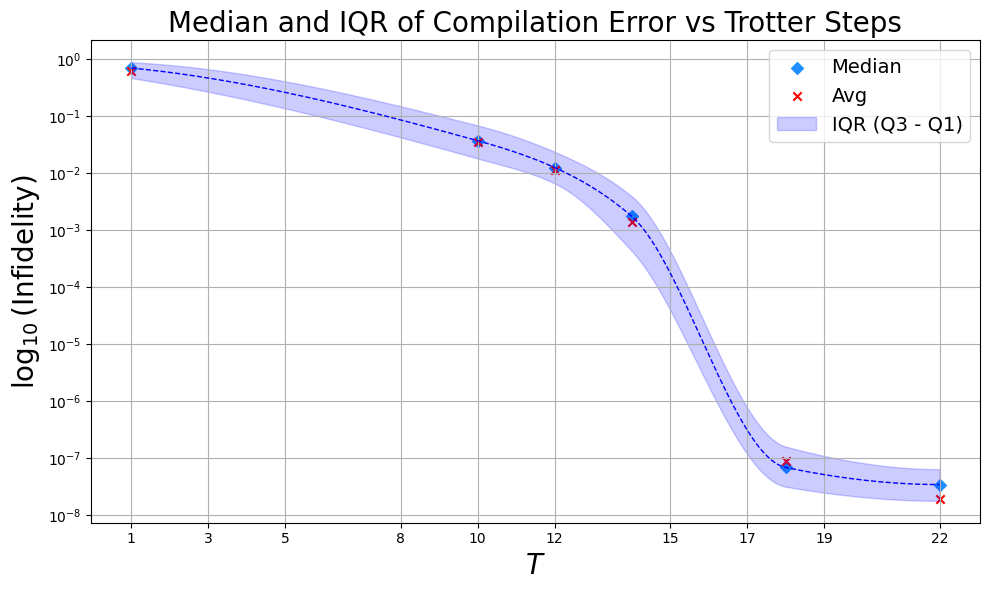

Filtering data for N_ctrl=2 and N_R=1...
Calculating mean +/- std/2 ...
[ 1 10 12 14 18 22]


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_50887/707839946.py:121: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


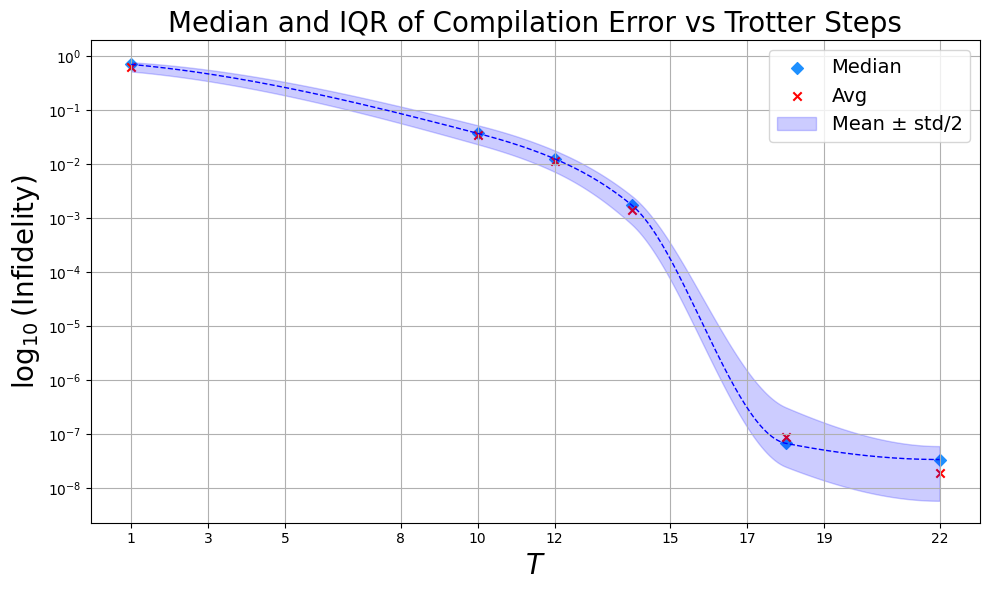

In [19]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
def plot_error_with_smoothed_bands(data_df, N_ctrl, N_R, xlabel, ylabel, title, 
                                   midpoint_metric='Total_Avg_Infidelity',
                                   std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for a list-based or scalar-based column.

    Args:
        data_df (pd.DataFrame): DataFrame containing columns like 'Trotter_Step', 'infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
        midpoint_metric (str): Column to treat as the 'central' value (e.g., average).
        std_metric (str): Column that may contain list(s) to compute median, IQR, etc.
    """

    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # Scalar metric, no flattening needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")

    print("Calculating median and IQR...")
    # Group by 'Trotter_Step' and calculate median, 20th, 80th percentile, mean, etc.
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            'median': np.median(np.concatenate(group[std_metric].values)),
            'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 20),
            'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 80),
            'avg': np.mean(np.concatenate(group[std_metric].values)),
            'std': np.std(np.concatenate(group[std_metric].values))
        }))
        .reset_index()
    )

    # Create PCHIP interpolators for a smooth curve
    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    # Fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)

    # Plot
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth, linestyle='--', lw=1, color='blue')
    plt.scatter(stats['Trotter_Step'], stats['median'], label='Median', marker='D', color='dodgerblue')
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2, label='IQR (Q3 - Q1)')

    # Optional: adjust y-ticks if you want powers-of-10 style
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick + 1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set a limited number of x-ticks
    num_ticks = 10
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])

    # Customize
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def plot_error_with_smoothed_bands_std(data_df, N_ctrl, N_R, xlabel, ylabel, title, 
                                       midpoint_metric='Total_Avg_Infidelity',
                                       std_metric='Error_Test_Results'):
    """
    Similar to plot_error_with_smoothed_bands but uses mean +/- (std/2) as the band.
    """

    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")

    print("Calculating mean +/- std/2 ...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            'median': np.median(np.concatenate(group[std_metric].values)),
            'q1': np.percentile(np.concatenate(group[std_metric].values), 25),
            'q3': np.percentile(np.concatenate(group[std_metric].values), 75),
            'avg': np.mean(np.concatenate(group[std_metric].values)),
            'lower_bound': np.mean(np.concatenate(group[std_metric].values)) - np.std(np.concatenate(group[std_metric].values)) / 2,
            'upper_bound': np.mean(np.concatenate(group[std_metric].values)) + np.std(np.concatenate(group[std_metric].values)) / 2
        }))
        .reset_index()
    )

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    pchip_mean = PchipInterpolator(stats['Trotter_Step'], stats['avg'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)

    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth, linestyle='--', lw=1, color='blue')
    plt.scatter(stats['Trotter_Step'], stats['median'], label='Median', marker='D', color='dodgerblue')
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2, label='Mean ± std/2')

    # Optional: adjust y-ticks for powers-of-10
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick + 1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # X-axis ticks
    print(stats['Trotter_Step'].unique())
    num_ticks = 10
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])

    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'N_R', 'N_C', 'N_params'])
    .agg({
        'infidelities': lambda x: np.concatenate(x.values),  # Flatten infidelities
        'Error_Test_Results': lambda x: np.concatenate(x.values),  # Flatten test results
         'Avg_infidelity': list,  # Aggregate floats into a list
        'Avg Error': list,  # Aggregate floats into a list
    })
    .reset_index()
)

# print(aggregated_data)

aggregated_data['Total_Avg_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Total_Avg_Infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Median_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.median(res)
)
aggregated_data['Median_infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.median(res)
)
# print(aggregated_data.head())

plot_error_with_smoothed_bands(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Total_Avg_Error',
    # midpoint_metric = 'Total_Avg_Error',
    std_metric = 'Error_Test_Results'
)
plot_error_with_smoothed_bands_std(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Avg Error',
    std_metric = 'Error_Test_Results'
)


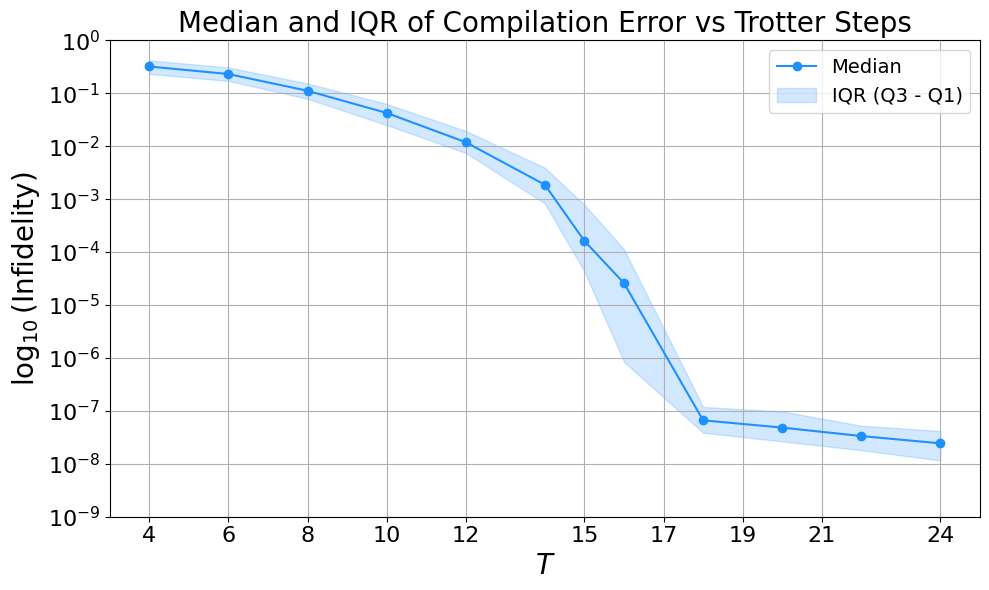

In [21]:
# Function to compute median and IQR for each Trotter step
def compute_error_statistics(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 25)  # 25th percentile
            q3 = np.percentile(exploded_values, 75)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

# Function to plot median with IQR as a shaded region and log scale applied after
def plot_error_with_iqr(data_df, N_ctrl,N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl
    # filtered_df = data_df[data_df['N_C'] == N_ctrl]
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    medians = [np.log10(median) for median, _, _ in statistics.values()]
    q1 = [np.log10(q1) for _, q1, _ in statistics.values()]
    q3 = [np.log10(q3) for _, _, q3 in statistics.values()]

    # Plot median and IQR
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, medians, label='Median', marker='o', color='dodgerblue')
    axs.fill_between(trotter_steps, q1, q3, color='dodgerblue', alpha=0.2, label='IQR (Q3 - Q1)')
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=2,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)



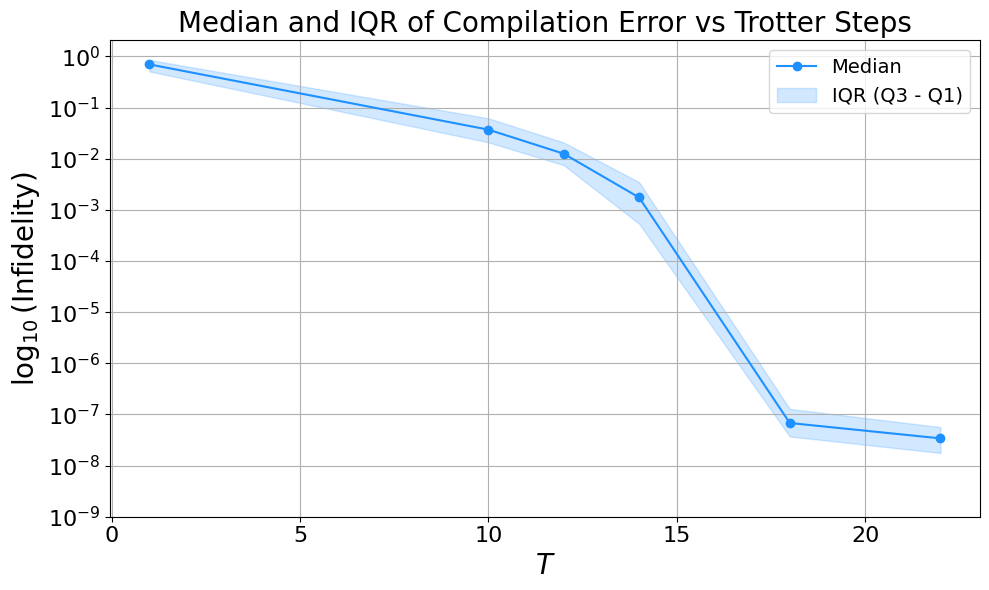

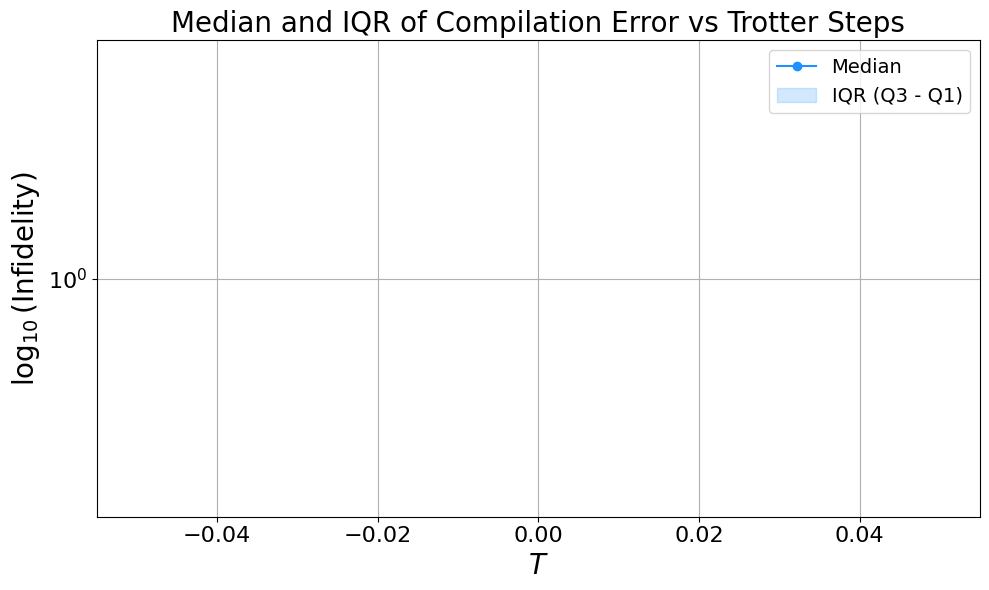

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compute median and IQR for each Trotter step
def compute_error_statistics(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 25)  # 25th percentile
            q3 = np.percentile(exploded_values, 75)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

# Function to plot median with IQR as a shaded region and log scale applied after
def plot_error_with_iqr(data_df, N_ctrl,N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl
    # filtered_df = data_df[data_df['N_C'] == N_ctrl]
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    medians = [np.log10(median) for median, _, _ in statistics.values()]
    q1 = [np.log10(q1) for _, q1, _ in statistics.values()]
    q3 = [np.log10(q3) for _, _, q3 in statistics.values()]

    # Plot median and IQR
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, medians, label='Median', marker='o', color='dodgerblue')
    axs.fill_between(trotter_steps, q1, q3, color='dodgerblue', alpha=0.2, label='IQR (Q3 - Q1)')

    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=2,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)


# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=3,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)


In [22]:
cached_data_temp =cached_data_digital



In [23]:
for N_ctrl in cached_data_temp:
    for gate, gate_data in cached_data_temp[N_ctrl].items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    original = results.get('test_results', [])
                    new_vals = []
                    for f in original:
                        if f > 1.0:
                            delta = f - 1.0       # how far above 1.0
                            reflected = 1.0 - delta  # reflect about 1.0
                            # If 'reflected' dips below 0 (which can happen if f>2),
                            # you might clamp it to 0.0 or do something else:
                            if reflected < 0:
                                reflected = 0.0
                            print(f"[PASS 1] Reflecting fidelity {f:.6f} about 1.0 => {reflected:.6f} "
                                  f"(Gate={gate}, N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step})")
                            new_vals.append(reflected)
                        else:
                            new_vals.append(f)
                    results['test_results'] = new_vals
for N_ctrl in cached_data_temp:
    for gate, gate_data in cached_data_temp[N_ctrl].items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    # Just clamp any test_results fidelity to <= 1.0
                    original = results.get('test_results', [])
                    clamped_vals = [min(1.0, f) for f in original]
                    results['test_results'] = clamped_vals
                    
tmp_rows = []
for N_ctrl in cached_data_temp:
    for gate, gate_data in cached_data_temp[N_ctrl].items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    row = {
                        'N_C': N_ctrl,
                        'Gate': gate,
                        'N_R': reservoir_count,
                        'Trotter_Step': trotter_step
                    }
                    # Include *all* keys from `results` so we don't drop anything
                    for k, v in results.items():
                        row[k] = v

                    tmp_rows.append(row)

tmp_df = pd.DataFrame(tmp_rows)
    
suspicious = tmp_df[
    (tmp_df['N_C']==2) & 
    (tmp_df['N_R']==1) & 
    (tmp_df['Trotter_Step']==16) &
     (tmp_df['Gate'] == 'U2_0') # or whichever row shows local_max=1.0
]
print("Result after pass 1")
for idx, row in suspicious.iterrows():
    arr = row['test_results']
    print(f"\nGate={row['Gate']} => test_results stats:")
    print(f"  Min={np.min(arr):.7e}, Max={np.max(arr):.3e}, Var={np.var(arr)}, Mean={np.mean(arr):.9f}")


def keep_iqr_5_95(arr):
    # If array empty or all identical, just return it
    if len(arr) < 2:
        return arr
    p5, p95 = np.percentile(arr, [5, 95])
    filtered = [x for x in arr if p5 <= x <= p95]
    # If everything got filtered out, you could decide to keep them all
    # or do something else. Here we allow an empty list if it's all outliers.
    return filtered if filtered else arr
# def keep_iqr_10_90(arr):
#     # If array empty or all identical, just return it
#     if len(arr) < 2:
#         return arr
#     p5, p95 = np.percentile(arr, [10, 90])
#     filtered = [x for x in arr if p5 <= x <= p95]
#     # If everything got filtered out, you could decide to keep them all
#     # or do something else. Here we allow an empty list if it's all outliers.
#     return filtered if filtered else arr
# tmp_df['test_results'] = tmp_df['test_results'].apply(keep_iqr_5_95)

# suspicious = tmp_df[
#     (tmp_df['N_C']==2) & 
#     (tmp_df['N_R']==1) & 
#     (tmp_df['Trotter_Step']==16) &
#      (tmp_df['Gate'] == 'U2_0') # or whichever row shows local_max=1.0
# ]
# print("Result after pass filtering IQR 5/95")
# for idx, row in suspicious.iterrows():
#     arr = row['test_results']
#     print(f"\nGate={row['Gate']} => test_results stats:")
#     print(f"  Min={np.min(arr):.7e}, Max={np.max(arr)}, Var={np.var(arr)}, Mean={np.mean(arr):.9f}")

tmp_df['avg_fidelity'] = tmp_df['test_results'].apply(
    lambda arr: np.mean(arr) if len(arr) else 1.0
)

group_cols = ['N_C', 'N_R', 'Trotter_Step']
tmp_df['local_max_avg_fid'] = (
    tmp_df.groupby(group_cols)['avg_fidelity'].transform('max')
)


def fix_any_ones_partially(row):
    arr = row['test_results']
    if len(arr) > 0 and any(x == 1.0 for x in arr):
        local_max = row['local_max_avg_fid']
        new_arr = []
        for x in arr:
            if x == 1.0:
                new_arr.append(local_max)
            else:
                new_arr.append(x)
        print(f"[PASS 2] Partially replacing any 1.0 entries "
              f"with local_max_avg_fid={local_max:.4e} "
              f"(Gate={row['Gate']}, N_C={row['N_C']}, "
              f"N_R={row['N_R']}, T={row['Trotter_Step']})")
        return new_arr
    return arr
tmp_df['test_results'] = tmp_df.apply(fix_any_ones_partially, axis=1)

suspicious = tmp_df[
    (tmp_df['N_C']==2) & 
    (tmp_df['N_R']==1) & 
    (tmp_df['Trotter_Step']==16) &
     (tmp_df['Gate'] == 'U2_0') # or whichever row shows local_max=1.0
]
print("Result after replacing any entry of a given test results array with the local max average fidelity")
for idx, row in suspicious.iterrows():
    arr = row['test_results']
    print(f"\nGate={row['Gate']} => test_results stats:")
    print(f"  Min={np.min(arr):.7e}, Max={np.max(arr)}, Var={np.var(arr)}, Mean={np.mean(arr):.9f}")

##############################################################################
# WRITE BACK THE UPDATED `test_results` INTO `cached_data_temp`
# so your original code snippet can run unmodified.
##############################################################################
for idx, row in tmp_df.iterrows():
    N_ctrl = row['N_C']
    gate = row['Gate']
    reservoir_count = row['N_R']
    trotter_step = row['Trotter_Step']
    
    # Find matching entry in the results_list
    results_list = cached_data_temp[N_ctrl][gate][reservoir_count][trotter_step]
    found_entry = False
    for results in results_list:
        # If you have a unique 'run' key, match on that
        if 'run' in row and results.get('run') == row['run']:
            results['test_results'] = row['test_results']
            found_entry = True
            break

    # If you have no unique ID, you must figure out a safe way to match
    # For now, we skip if not found:
    if not found_entry:
        pass



##############################################################################
# PASS 2: RUN YOUR ORIGINAL CODE TO BUILD THE FINAL `all_data_df` WITH ALL KEYS
##############################################################################
rows = []
negative_fidelity_values = []

global_min_error = 100  # from your snippet
N_ctrls = [2]        # or whatever your loop over N_ctrl is

for N_ctrl in N_ctrls:
    data_i = cached_data_temp[N_ctrl]
    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    avg_fidelity = results.get('fidelity', np.nan)
                    std_fidelity = np.nanstd(results.get('test_results', []))

                    if pd.isna(avg_fidelity):
                        raise ValueError(
                            f"NaN in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                            f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, "
                            f"Run: {results.get('run', None)}"
                        )

                    log_infidelities = []
                    infidelities, fidelities = [], []
                    num_clipped = {}
                    all_og_fidelities = {}

                    test_results = results.get('test_results', [])
                    optimal_min_error = None
                    optimal_jitter_scale = None

                    # Step 1: dynamic min_error + jitter
                    non_clipped_fids = [
                        f for f in test_results
                        if 0 < f < 1.0
                    ]
                    if non_clipped_fids:
                        sorted_valid = sorted(non_clipped_fids)
                        n = len(sorted_valid)
                        std_dev = np.std(sorted_valid)
                        std_err = std_dev / np.sqrt(n) if n > 1 else global_min_error
                        optimal_min_error = 1.0 - sorted_valid[-1]
                        if global_min_error > optimal_min_error:
                            global_min_error = max(1e-9, optimal_min_error)
                        optimal_jitter_scale = (
                            std_dev / 2
                            if std_dev/2 < optimal_min_error
                            else optimal_min_error
                        )
                    else:
                        optimal_min_error = global_min_error
                        optimal_jitter_scale = global_min_error

                    # Step 2: Process each fidelity
                    clipped_count = 0
                    for i, f in enumerate(test_results):
                        all_og_fidelities[i] = f
                        inf = 1.0 - f

                        if inf <= 1e-8:
                            clipped_count += 1
                            jitter = np.random.uniform(-optimal_jitter_scale, 
                                                       optimal_jitter_scale)
                            num_clipped[i] = {'fidelity': f, 'jit': jitter}
                            inf = optimal_min_error + jitter
                            print(f'triggered')
                            print(f"\nGate={results['gate']} => test_results stats:")
                            print(f"  Min={np.min(test_results):.7e}, Max={np.max(test_results)}, Var={np.var(test_results)}, Mean={np.mean(test_results):.9f}")
                            assert inf > 0, (
                                f"Adjusted infidelity is non-positive: i={i}, "
                                f"min_error={optimal_min_error}, jitter={jitter}."
                            )
                            f = 1.0 - inf

                        infidelities.append(inf)
                        fidelities.append(f)
                        log_infidelities.append(np.log10(inf))

                    # Step 3: Build row
                    avg_fidelity = np.mean(fidelities)
                    avg_infidelity = np.mean(infidelities)

                    row = {
                        'N_C': int(N_ctrl),
                        'Trotter_Step': int(trotter_step),
                        'Gate': results['gate'],
                        'N_R': int(reservoir_count),
                        'Avg_Fidelity': avg_fidelity,
                        'std_fidelity': std_fidelity,
                        'Avg_infidelity': avg_infidelity,
                        'var_infid': np.var(infidelities),
                        'Error_Test_Results': log_infidelities,
                        'Avg Error': (np.nanmean(log_infidelities) 
                                      if log_infidelities else np.nan),
                        'infidelities': infidelities,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': results.get('param_count', np.nan),
                        'run': results.get('run', None),
                        'indices_clipped': num_clipped,
                        'all_og': all_og_fidelities,
                        'Optimal_min_error': optimal_min_error,
                        'Optimal_jitter_scale': optimal_jitter_scale,
                    }

                    rows.append(row)

all_data_df = pd.DataFrame(rows)

Result after pass 1
Result after replacing any entry of a given test results array with the local max average fidelity
triggered

Gate=U2_0 => test_results stats:
  Min=9.9999991e-01, Max=0.9999999999849196, Var=2.6238631896973433e-16, Mean=0.999999970
triggered

Gate=U2_0 => test_results stats:
  Min=9.9999991e-01, Max=0.9999999999849196, Var=2.6238631896973433e-16, Mean=0.999999970
triggered

Gate=U2_0 => test_results stats:
  Min=9.9999991e-01, Max=0.9999999999849196, Var=2.6238631896973433e-16, Mean=0.999999970
triggered

Gate=U2_0 => test_results stats:
  Min=9.9999991e-01, Max=0.9999999999849196, Var=2.6238631896973433e-16, Mean=0.999999970
triggered

Gate=U2_0 => test_results stats:
  Min=9.9999991e-01, Max=0.9999999999849196, Var=2.6238631896973433e-16, Mean=0.999999970
triggered

Gate=U2_0 => test_results stats:
  Min=9.9999991e-01, Max=0.9999999999849196, Var=2.6238631896973433e-16, Mean=0.999999970
triggered

Gate=U2_0 => test_results stats:
  Min=9.9999991e-01, Max=0.999999

global_min_y: -15.893007497355239, global_max_y: -0.0012666403166308156
global_min_fidelity: 0.3275579510009069, global_max_fidelity: 0.999999957007893


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_50887/1711527331.py:124: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='N_R', data=test_results_df,


y ticks: [-16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.], -16
[-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.]


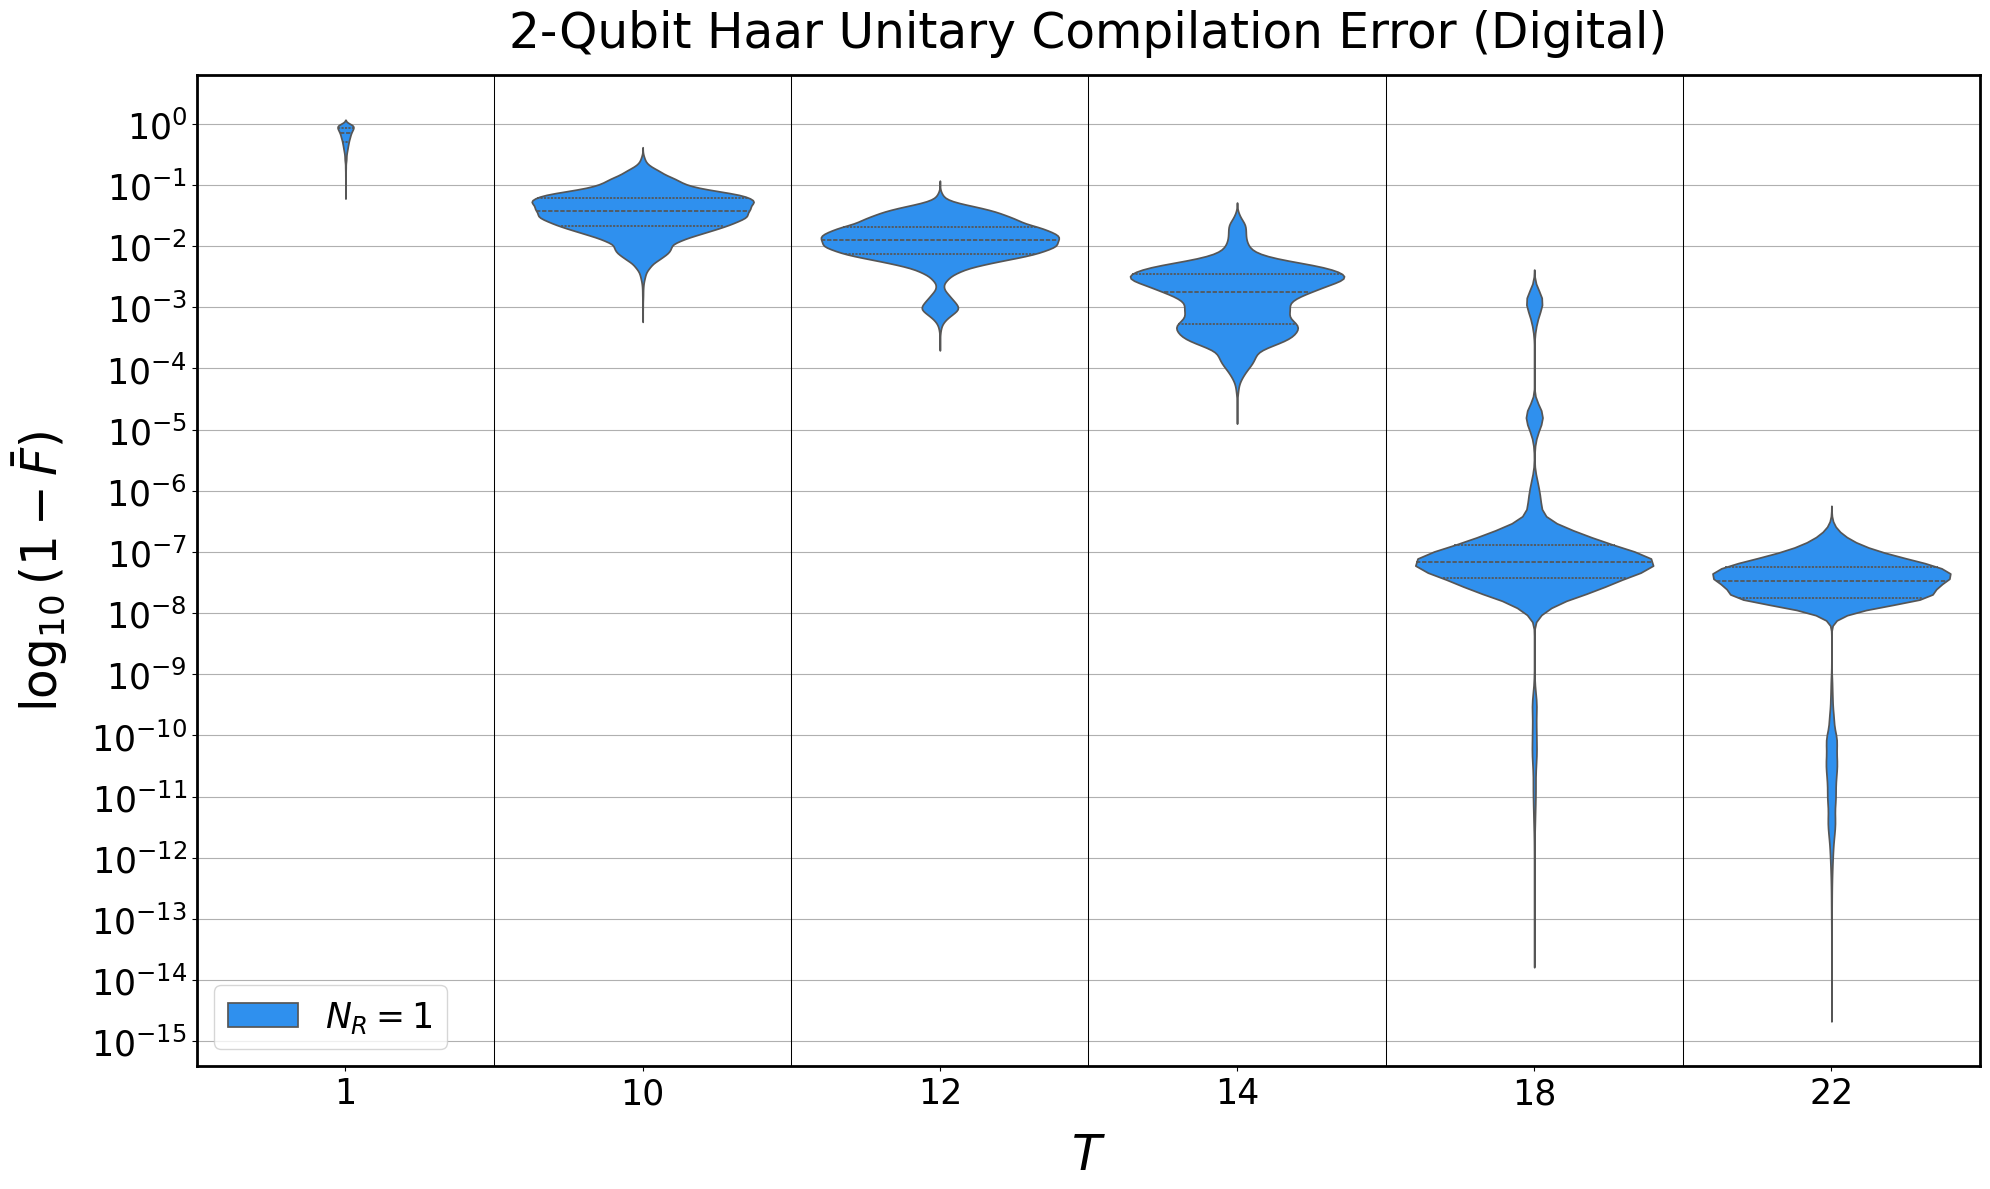

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_50887/1711527331.py:188: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_filtered,


y ticks: [-10.  -8.  -6.  -4.  -2.   0.   2.]
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


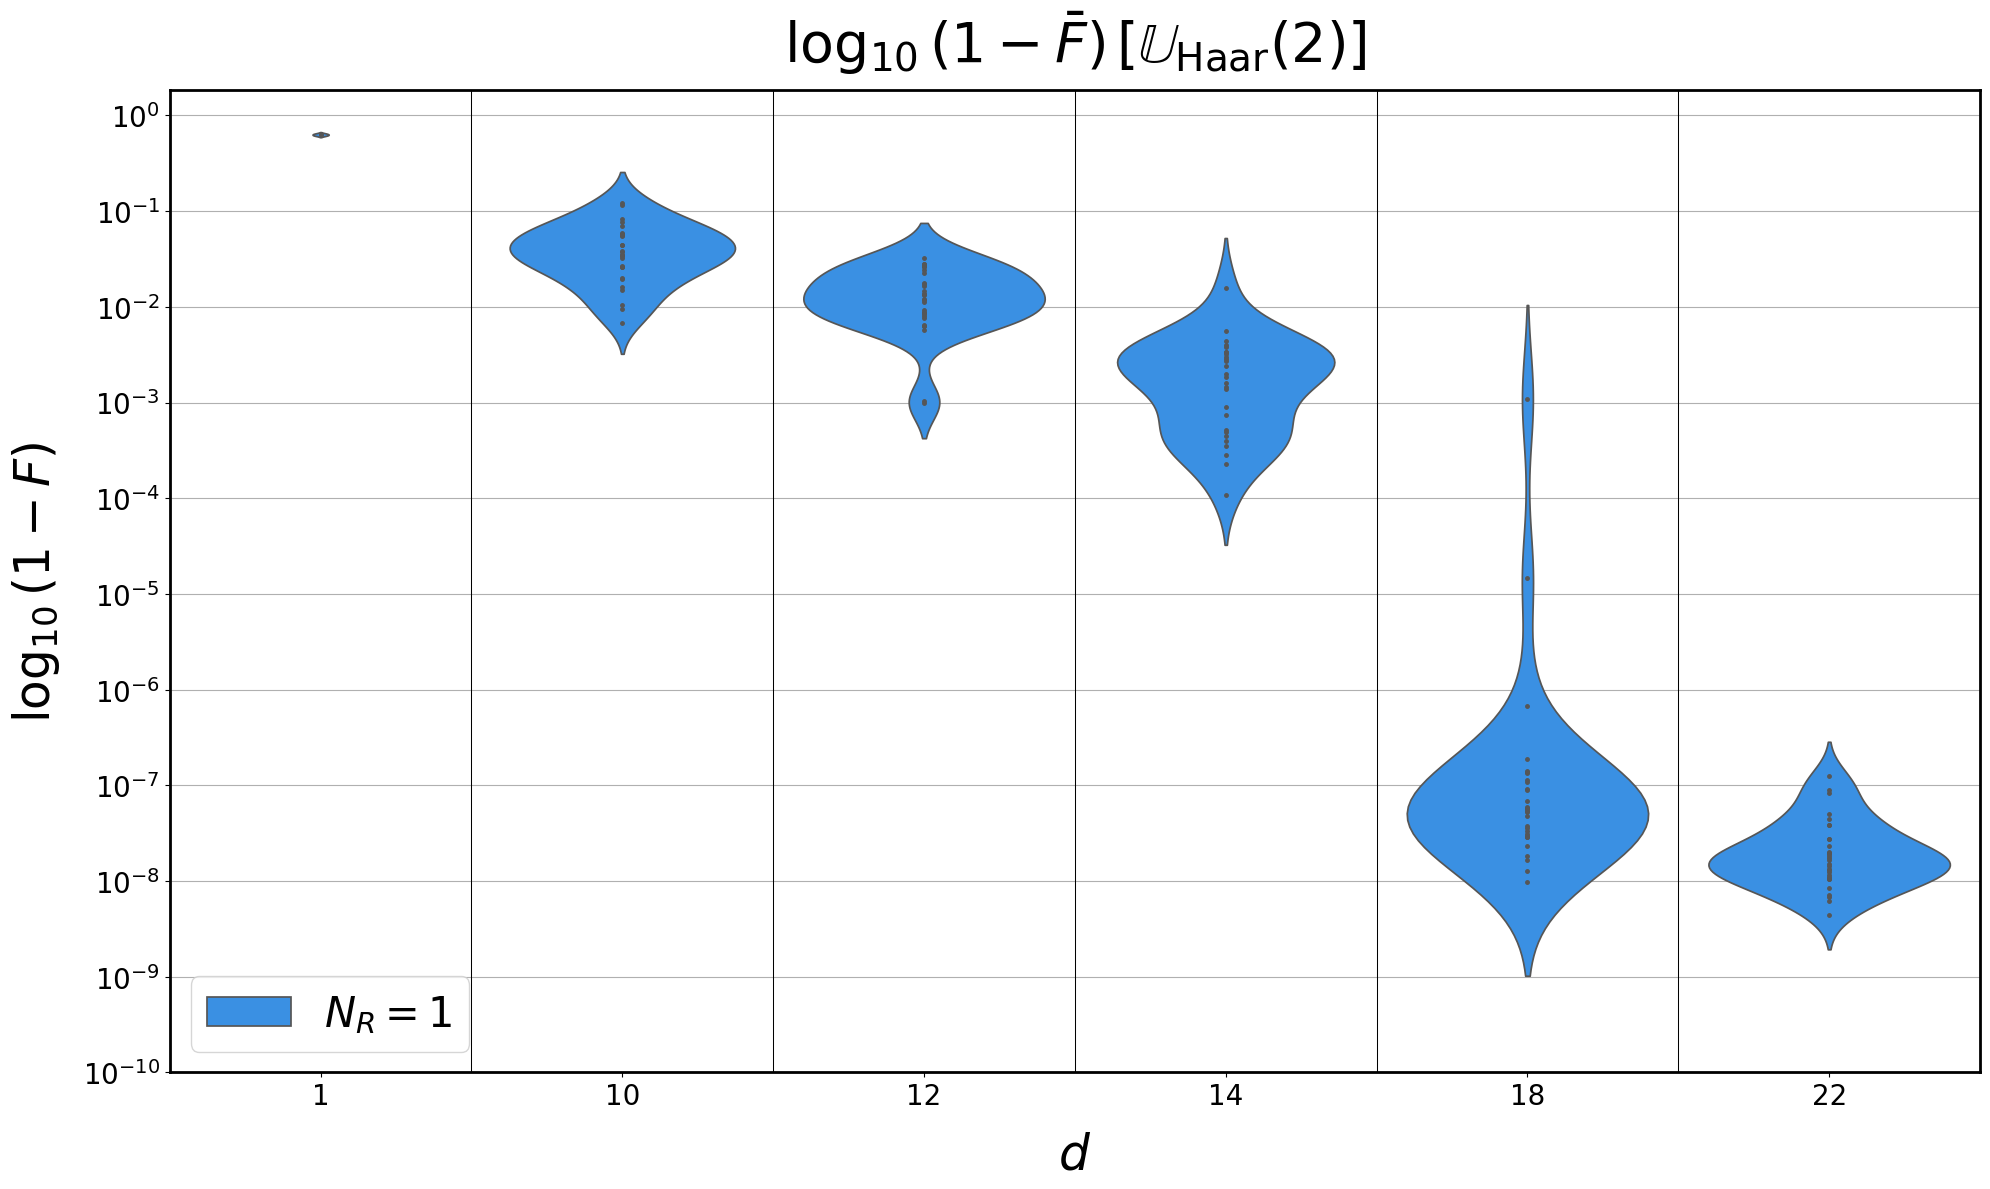

In [24]:
# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_max_y = float('-inf')
global_min_fidelity = float('inf')
global_max_fidelity = float('-inf')

custom_palette = ['dodgerblue', 'gold', 'violet'] 
plt.close('all')  # Close previous figures to avoid conflicts
N_ctrls = [2]
resies = [1,2,3,4,5,6,7,8,9]
resies = [1]
for N_ctrl in N_ctrls:
    trots = np.arange(1,23,1)
    
    if N_ctrl == 2:
        trots = set(trots)
        # trots.remove(np.int64(6))
        
    elif N_ctrl == 1:
        trots = set(trots)
        
    elif N_ctrl == 3:
        trots = set(trots)
        trots.remove(np.int64(32))
        trots.remove(np.int64(36))
        trots.remove(np.int64(1))
        trots.remove(np.int64(42))
        trots.remove(np.int64(47))

    
    

    trots = list(trots)
    # if N_ctrl == 2:
    #     # trots = [1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14, 16, 17,18, 20, 22, 24, 26, 28]
    #     trots =[4,6,8,10,12,14,18]
        
    # elif N_ctrl == 1:
    #     trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10]
    #     # resies = [1,2,3]
    # else:
    #     trots = np.arange(1, 51, 1)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Aggregate average fidelity by Trotter_Step and N_R
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'N_R'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)

# Add a slight margin to avoid cutoff on the plot
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y += margin_factor * abs(global_max_y)

print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")
plot_avgered = True
custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    trots = np.arange(1,23,1)
    
    if N_ctrl == 2:
        trots = set(trots)
        # trots.remove(np.int64(6))
        
    elif N_ctrl == 1:
        trots = set(trots)
        
    elif N_ctrl == 3:
        trots = set(trots)
        trots.remove(np.int64(32))
        trots.remove(np.int64(36))
        trots.remove(np.int64(1))
        trots.remove(np.int64(42))
        trots.remove(np.int64(47))
    trots = list(trots)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['N_R'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error_Test_Results')

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Drop rows with NaN values in 'Error_Test_Results' to avoid errors
    test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    # sns.violinplot(x='Trotter_Step', y='infidelities', hue='N_R', data=test_results_df, 
    #                ax=axs,width=0.8, palette=custom_palette,log_scale=True, density_norm='count', inner='quartile', saturation=0.85)
    sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='N_R', data=test_results_df, 
                   ax=axs,width=0.8, palette=custom_palette,density_norm='count', inner='quartile', saturation=0.85)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # # Set the global Y-limits
    # axs.set_ylim(global_min_y, global_max_y)

    # # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    print(f"y ticks: {y_ticks}, {round(global_min_y)}")
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = round(global_min_y)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
    print(whole_y_ticks)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    # plt.tight_layout(pad=3.0)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()
    if plot_avgered:
        # Filter the DataFrame for specific Trotter_Steps
        data_filtered = data_df[data_df['Trotter_Step'].isin(trots)]

        ### First Violin Plot for Average Error ###

        fig, axs = plt.subplots(1, figsize=(20, 12))

        # Set the linewidth of the outside border (spines)
        for spine in axs.spines.values():
            spine.set_linewidth(2)  # Set linewidth to 2 pixels

        # Violin Plot for Average Error (log10(1 - avg_fidelity))
        sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_filtered, 
                    ax=axs, palette=custom_palette, density_norm='count', inner="point")

        # Set titles and labels with padding
        axs.set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=40, pad=20)
        axs.set_xlabel('$d$', fontsize=35, labelpad=15)  # X-axis label with padding
        axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=35, labelpad=15)  # Y-axis label with padding

        # Add grid lines
        axs.yaxis.grid(True)
        axs.xaxis.grid(False)
        axs.set_axisbelow(True)

        # Customize the legend
        handles, labels = axs.get_legend_handles_labels()
        axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30)

        # Set Y-ticks and labels
        y_ticks = axs.get_yticks()
        print(f"y ticks: {y_ticks}")
        whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
        # print(whole_y_ticks)
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        print(whole_y_ticks)
        
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

        # Set tick parameters
        axs.tick_params(axis='y', labelsize=20) 
        axs.tick_params(axis='x', labelsize=20) 

        # Add vertical lines to separate groups
        unique_trotter_steps = data_filtered['Trotter_Step'].unique()
        positions = range(1, len(unique_trotter_steps), 1)
        for pos in positions:
            axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

        # Show the plot
        plt.tight_layout()
        plt.show()